# Radar Class Lab #1 - Chirp Compression
## Instructions

This is a [Jupyter Notebook](https://jupyter.org/index.html). It is made up of "cells" containing either Python code or [Markdown text](https://www.markdownguide.org/getting-started/) and [LaTeX](https://www.latex-project.org/about/) (this one, for example, contains markdown text). Press shift+enter on your keyboard or hit the run key at the top of this window to run the selected cell (shown by the blue bar on the left side of this window). Make sure to run the code cell immediately after this before running any other code cells, as all the rest rely on it. After running the next code cell you can run the rest of the code cells in any order. 

In [3]:
# Michael Christoffersen
# January 2020

%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sigUtil as sig

## Part 1 - Some Digital Signal Basics
### Digital Sampling
The lab will begin with a short refresh on some important digital signal processing concepts. But first - recall that the equation for a sine wave with amplitude $A$ (units: arbitrary), initial phase $\phi$ (units: radians), and angular frequency $w$ (units: radians/second) is:

$$\begin{equation}\tag{1} g(t) = A\cdot sin(\omega t + \phi)\end{equation}$$ 

However it is more useful to work in hertz (cycles/second) which are related to radians by a factor of 2$\pi$ - so an alternate formulation where $f$ is frequency in hertz is:

$$\begin{equation}\tag{2} g(t) = A\cdot sin(2\pi ft + \phi)\end{equation}$$

In the markdown block below write an expression for a 12 Hz sine wave with an amplitude of 2 and an initial phase of $\pi$. Format it with LaTeX (hint - look at the equations in this cell). If the block has been executed already you can double click on the text to edit it.

**Equation here**

By nature of being on a computer, all signals in this lab are digital (as opposed to analog). This means they are not continuious functions, but rather a set of discrete points stored in the computer. The plot generated by the code below should help visualize this difference. The red line is a sine wave, sampled extremely densely so that is appears to be continuious, like an analog signal. The blue dots are examples of digital "samples" that would be taken from the red sine wave - how a computer might store a digital version of the "analog" red signal. It is important to note that the red line is in fact a digital signal as well, but appears analog to our eyes. 

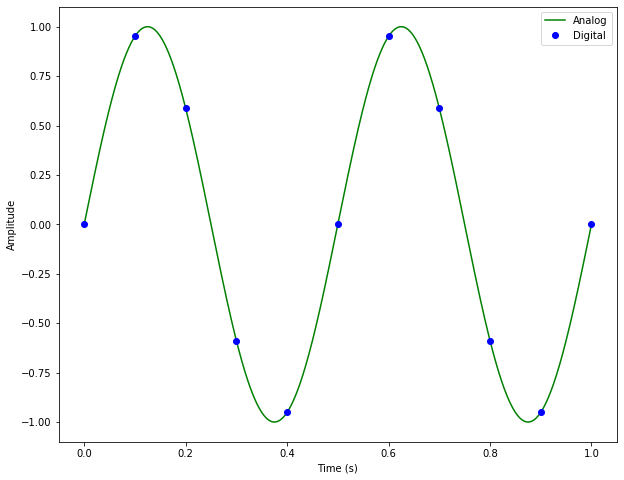

In [3]:
# Generate time arrays, samples increasing at a constant frequency
# arangeT has arguments (start time, stop time, sampling frequency)
tAnalog = sig.arangeT(0, 1, 1000)   # 0 to 1s, at 1000 Hz - Faking an analog signal
tDigital = sig.arangeT(0, 1, 10)    # 0 to 1s, at 10 Hz

# Evaluate sine functions - f = 2 Hz
sAnalog = np.sin(2 * np.pi * 2 * tAnalog)
sDigital = np.sin(2 * np.pi * 2 * tDigital)

# Make plot
fig=plt.figure(figsize=(10, 8))
plt.plot(tAnalog, sAnalog, 'g-')   # (x,y,style)
plt.plot(tDigital, sDigital, 'bo')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(["Analog", "Digital"])
plt.show()

One of the imports in the first code cell is a file called "sigUtil" that is included with this lab. Open it up and inspect it - there are several functions defined that will be useful to you in this lab. Some are incomplete and will be filled in by you later.

### Nyquist Theorem
Paraphrased, the Nyquist theorem states that in order to digitally capture a signal of frequency $f$, it must be sampled at a frequency greater than $2f$. For example, if I want to digitally capture a 15 Hz sine wave, I must sample it at a frequency of greater than 30 Hz. Sampling at a rate less than $2f$ will lead to "aliasing", illustrated in the plot below.

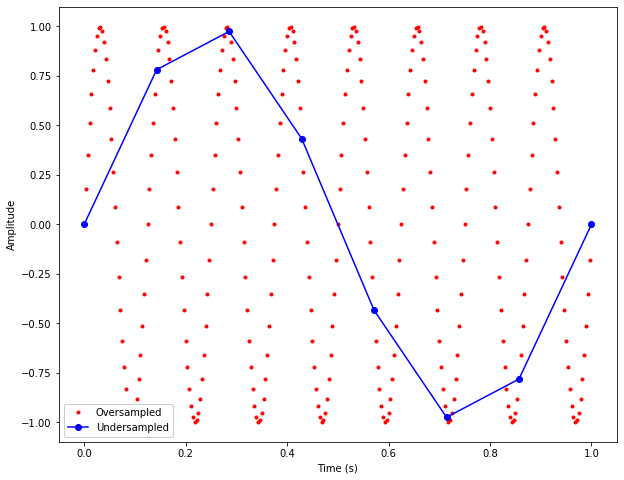

In [40]:
tOverNyq = sig.arangeT(0, 1, 280)   # 0 to 1s, at 280 Hz   
tUnderNyq = sig.arangeT(0, 1, 7)    # 0 to 1s, at 6 Hz

# Evaluate sine functions - f = 8 Hz
sOverNyq = np.sin(2*np.pi*8*tOverNyq)
sUnderNyq = np.sin(2*np.pi*8*tUnderNyq)

fig=plt.figure(figsize=(10, 8))
plt.plot(tOverNyq, sOverNyq, 'r.')
plt.plot(tUnderNyq, sUnderNyq, 'bo-')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(["Oversampled","Undersampled"], loc = 'lower left', framealpha = 1)
plt.show()

You can see that even though both of the waveforms are samples from an 8 Hz sine wave, the undersampled waveform appears to be a 1 Hz sine wave. This is aliasing - the 8 Hz signal aliased to 1 Hz because it was sampled at 6 Hz, well below its nyquist frequency of 16 Hz.

### Fourier Series and Discrete Fourier Transforms
The important thing to remember about Fourier series for this lab is that they are a way to represent a function in terms of its frequency constituents (i.e., a set of sinusoids at different frequencies that can be summed to produce the function). All periodic functions and finite intervals of non-periodic functions can be represented in this way. We can represent digital timeseries in this manner too by using a discrete fourier transform (DFT). The code below is a demonstration of this concept.

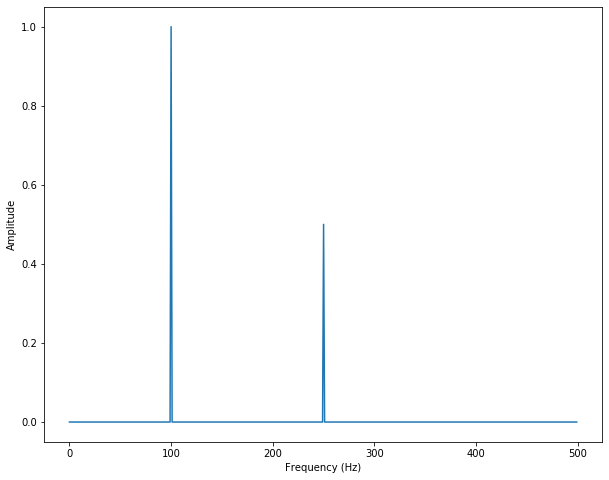

In [41]:
# Sample for 1 second at 1 kHz
fs = 1e3
t = sig.arangeT(0,1,fs)

# Create a 100 Hz sine wave and a 250 Hz sine wave
s1 = np.sin(2*np.pi*100*t)
s2 = np.sin(2*np.pi*250*t)

# Combine them, but halve the amplitude of s2 to .5
s0 = s1 + s2*.5

# Take the DFT (with an algorithm called a Fast Fourier Transform - FFT)
S0 = np.fft.fft(s0)

# Scale based on the length of the signal
S0 = S0/(len(s0)/2)

# Calculate DFT frequency spacing
fInt = fs/len(S0)
fBins = fInt*np.arange(0,len(S0)//2,1)*fInt

# Grab half of DFT for plot
S0 = S0[0:len(S0)//2]

fig=plt.figure(figsize=(10, 8))
plt.plot(fBins, np.abs(S0))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

Notice the two spikes at 100 Hz and 250 Hz that are porportional to the amplitude of the components of s0 at the two frequencies. Try adding a third frequency component at 400 Hz with an amplitude of two.

## Part 2 - Chirps
Unlike the signals used for the examples in Part 1, which maintain a constant frequency, chirps are sinusoids that change in frequency over time. All of the chirps that you will be working with in this lab change frequency linearly with time, however other types of chirps exist. In class you learned why chips are so useful for radar - they allow both high power and high resolution. Now you will learn how to generate them in software. The equation of a sine wave that changes frequency over time is a little more complex than Equation 1, so we will derive it below.

A more general equation for a sine wave uses only amplitude ($A(t)$) and phase ($\Phi(t)$), each being a function of time: 

$$\begin{equation}\tag{3}g(t)=A(t)\cdot sin(\Phi(t))\end{equation}$$

Angular frequency is, by definition, the rate of change of the phase of a sinusoid - i.e.:

$$\begin{equation}\tag{4}\omega=\frac{\delta\Phi}{\delta t}\end{equation}$$

So to to obtain $\Phi(t)$ for a constant angular frequency $\omega$, we integrate:

$$\begin{equation}\tag{5}\Phi(t)=\int(\omega)dt=\omega t + c\end{equation}$$

Then we can plug it in to Equation 3, using $\phi$ instead of $c$ for the constant term. For the rest of this section we will assume amplitude is constant, so $A(t)=A$:

$$\begin{equation}\tag{6}g(t)=A\cdot sin(\omega t + \phi)\end{equation}$$

and we see that we have derived Equation 1 - a mono-frequency sine wave. 

Now what if the frequency of our sinusoid is not constant, but varies linearly with time such that $\omega(t) = \alpha t + \omega_0$ where $\alpha$ is the rate of angular frequency change and $\omega_0$ is the initial angular frequency? Applying Equation 4 again:

$$\begin{equation}\tag{7}\Phi(t)=\int(\alpha t + \omega_0)dt = \textstyle\frac{1}{2}\alpha t^2 + \omega_0 t+ \phi \end{equation}$$

Then plugging this in to Equation 3:

$$\begin{equation}\tag{8}g(t)=A\cdot sin(\textstyle\frac{1}{2}\alpha t^2 + \omega_0 t+ \phi)\end{equation}$$

This is the equation of a chirp. It can be re-written in in terms of hertz as:

$$\begin{equation}\tag{9}g(t)=A\cdot sin(2\pi(\textstyle\frac{1}{2}\beta t^2 + f_0 t) + \phi)\end{equation}$$

Where $\beta$ is the rate of frequency changed in hertz per second and $f_0$ is the initial frequency in hertz. Let's apply Equation 9 and generate a 1 second chirp from 5 to 15 Hz with an initial phase of $\pi$.

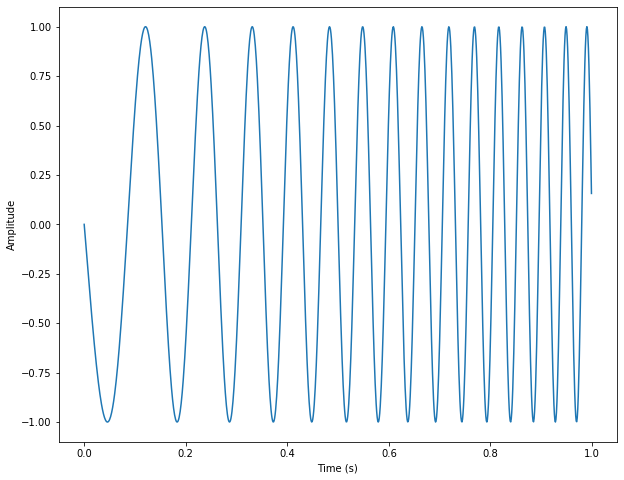

In [42]:
fs = 1e3  # 1 kHz well above nyquist for 25 Hz
t = sig.arangeT(0,1,fs) # Sample for 1 second 

f0 = 5   # Hz
f1 = 25  # Hz
b = (f1-f0)/1  # Rate of frequency change - ((f1-f0)/T)

c = np.sin(2*np.pi*(.5*b*np.square(t) + f0*t) + np.pi)

fig=plt.figure(figsize=(10, 8))
plt.plot(t,c)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

We can inspect the FFT of a chirp to see that is does have power over the range of frequencies in the sweep.

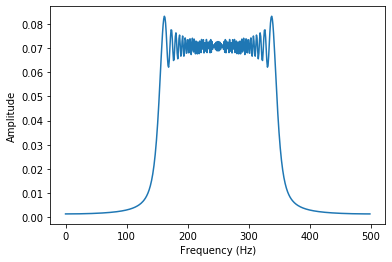

In [19]:
# Higher bandwidth than earlier chirp
fs = 1e3 # 1 kHz
t = sig.arangeT(0,1,fs) # Sample for 1 second 

f0 = 150   # Hz
f1 = 350  # Hz
b = (f1-f0)/1  # Rate of frequency change - ((f1-f0)/T)

c = np.sin(2*np.pi*(.5*b*np.square(t) + f0*t) + np.pi)

# Take the DFT (with an algorithm called a Fast Fourier Transform - FFT)
C = np.fft.fft(c)

# Scale based on the length of the signal
C = C/(len(c)/2)

# Calculate DFT frequency spacing
fInt = fs/len(C)
fBins = fInt*np.arange(0,len(C)//2,1)*fInt

# Grab half of DFT for plot
C = C[0:len(C)//2]

fig=plt.figure(figsize=(10, 5))
plt.clf()
plt.plot(fBins, np.abs(C))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

Why is the frequency spectrum of the chirp not flat?

An aside related to Thursday's class, if you saturate your ADC and cause clipping of the returned signal the frequency spectrum of your returned chirp will be butchered, reducing the quality of the chirp compression. The example below uses the same chirp as the example above, but clips it at an amplitude greater than .5, equivalent to exceeding the maximum input power of the ADC by about 3 dB

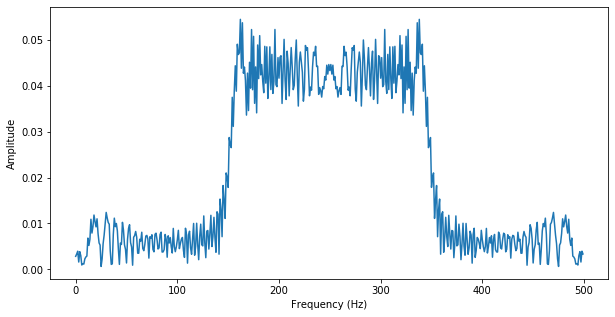

In [12]:
# Higher bandwidth than earlier chirp
fs = 1e3 # 1 kHz
t = sig.arangeT(0,1,fs) # Sample for 1 second 

f0 = 150   # Hz
f1 = 350  # Hz
b = (f1-f0)/1  # Rate of frequency change - ((f1-f0)/T)

c = np.sin(2*np.pi*(.5*b*np.square(t) + f0*t) + np.pi)

# Clip chirp
c[c > .5] = .5
c[c < -.5] = -.5

# Take the DFT (with an algorithm called a Fast Fourier Transform - FFT)
C = np.fft.fft(c)

# Scale based on the length of the signal
C = C/(len(c)/2)

# Calculate DFT frequency spacing
fInt = fs/len(C)
fBins = fInt*np.arange(0,len(C)//2,1)*fInt

# Grab half of DFT for plot
C = C[0:len(C)//2]

fig=plt.figure(figsize=(10, 5))
plt.plot(fBins, np.abs(C))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

In the code box below generate and plot your own chirp - 5 milliseconds long, sweeping from 2.5 to 7.5 kHz with an amplitude of 2 and initial phase of 0. Sampled at an appropriate frequency.

In [17]:
# Generate and plot the chirp here


Now, complete the "chirp" function in sigUtil so that you can use it later on in the lab.

## Part 3 - Time Domain Chirp Compression
Chirp compression is a cross-correlation between data and the assumed transmitted signal. There is a "corr" function included in sigUtil which will perform this operation. Open sigUtil and look through the function, then use it to complete the pulse compression code below.

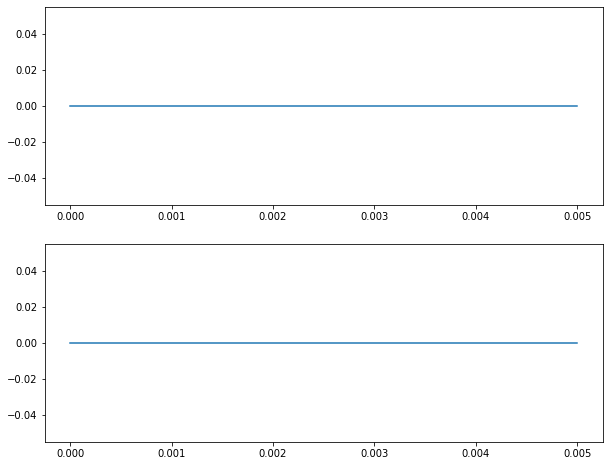

In [8]:
# Generate a chirp
c = sig.chirp(5e-3, 1e3, 5e3, 0, 100e3)

# Fake data trace
s = np.append(np.zeros(500),c)

ts = sig.arangeN(len(s), 100e3)

### Change this line to perform cross correlation between c and s ###
xc = np.zeros(len(ts))

fig=plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(ts, s)
plt.subplot(2,1,2)
plt.plot(ts, xc)
plt.show()

Pulse compression is extremely effective at extracting very weak signals that appear to be below noise. Complete the following example with the corr function to demonstrate this.

In [10]:
# Generate a 5 to 25 kHz chirp
c = sig.chirp(5e-3, 5e3, 25e3, 0, 100e3)
c = c*.5

# Make a noisy signal and embed the chirp in it
s = np.random.normal(size = 5000)

# RMS SNR code goes here
rmsC = np.sqrt(np.mean(np.square(c)))

s[3000:3000+len(c)] = s[3000:3000+len(c)] + c

### Change this line to perform cross correlation between c and s ###
xc = np.zeros(len(xc))

fig=plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(s)
plt.subplot(2,1,2)
plt.plot(xc)
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

Add some code to the cell abov to calculate an RMS signal to noise ratio before pulse compression.

## Part 4 - Frequency Domain Chirp Compression
Chirp compression can be performed in the frequency domain much quicker than in the time domain thanks to the invention of [$O(NlogN)$](https://en.wikipedia.org/wiki/Big_O_notation) fast fourier transform algorithms - time domain correlation is an $O(N^2)$ operation. Your assignment here is to implement chirp compression in the frequency domain using the algorithm described below. In sigUtil there is a function definition called "corrFFT" - fill in this function. Numpy has many useful functions, such as fft, that will be helpful when doing this. Documentation lives [here](https://docs.scipy.org/doc/numpy/reference/) but it is probably easier just to google "numpy _____" when you are looking for something. Looking at the corr function in sigUtil may help with some of the data handling mechanics.

1. Generate a reference chirp
2. Zero-pad the end of the reference chirp to the length of the data
3. Take the fft of both the reference chirp and the data
4. Take the complex conjugate of the reference chirp - this is equivalent to reversal in the time domain
5. Multiply by element the complex conjugate of the reference chirp and the data - this is eqivalent to correlation in the time domain
6. Take the inverse fft of the result

When you have finished the algorithm run the code below - the output should be identical to the first example in part 3.

ValueError: x and y must have same first dimension, but have shapes (501,) and (1,)

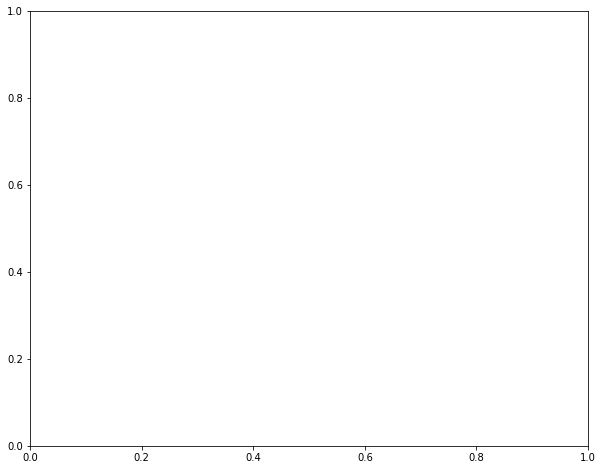

In [11]:
# Generate a chirp
c = sig.chirp(5e-3, 1e3, 5e3, 0, 100e3)

# Fake data trace
s = np.append(np.zeros(500),c)
ts = sig.arangeN(len(s), 100e3)

# Frequency domain cross correlation
xc = sig.corrFFT(c, s)

fig=plt.figure(figsize=(10, 8))
plt.plot(ts, xc)
plt.show()

## Part 5 - Windowing

Windowing functions are often used in pulse compression to reduce sidelobes at the cost of resolution and main lobe amplitude. There are many different windows, and new ones are still being formulated. The next cell is a demonstration of the effect windowing has on a signal, comparing a rectangular window to a [hamming window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows). The difference in the heights of the main lobes looks dramatic in linear space (how the graph is presented), but the ratio between the max amplitudes is ~1.855, 2.6 dB. 

ValueError: x and y must have same first dimension, but have shapes (1002,) and (1,)

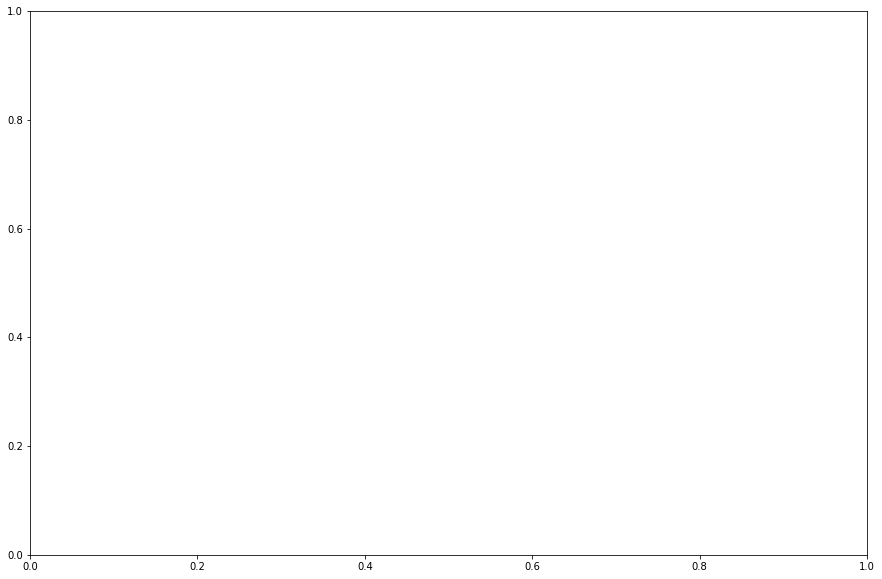

In [13]:
t = sig.arangeT(0,5e-3,100e3)
ts = sig.arangeT(0,10e-3+1/100e3,100e3)

# Chirp slope
m = 4e3/5e-3

# Generate baseband chirp
i = np.complex(0,1)
c = np.exp(2*np.pi*i*(.5*m*t*t + -2e3*t))

# Fake trace
s = np.append(np.zeros(len(c)),c)

# Make windowed chirp
cwHamm = c * np.hamming(len(c))

# Windowed and non-windowed pulse compression
xc = sig.corrFFT(c,s)
xcwHamm = sig.corrFFT(cwHamm,s)

fig=plt.figure(figsize=(15, 10))
plt.plot(ts*1e3, xc, ts*1e3, xcwHamm)
plt.legend(["Rectangular", "Hamming"])
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

## Part 6 - Application to Real Data

Included with this lab is a file called "20180819-214243.dat" which contains real radar data from an August 2018 airborne radar sounding campaign in Southern Alaska. Your job is to pulse compress this data. In sigUtil there is a function called "loadData" which you can use to load the data into a 2D array. The data is sampled at 50 MHz and was acquired with a 4 $\mu$s chirp that swept from 1.25 to 3.75 MHz. It may help to apply a window to reduce sidelobes from the surface reflection. The easiest way to display an image will taking the log of the square of the data and then using that with plt.imshow(). Use whatever [colormap](https://matplotlib.org/tutorials/colors/colormaps.html) you want - I normally go with "Greys_r". Tweak the vmin and vmax arguments to imshow to get a happy display. 

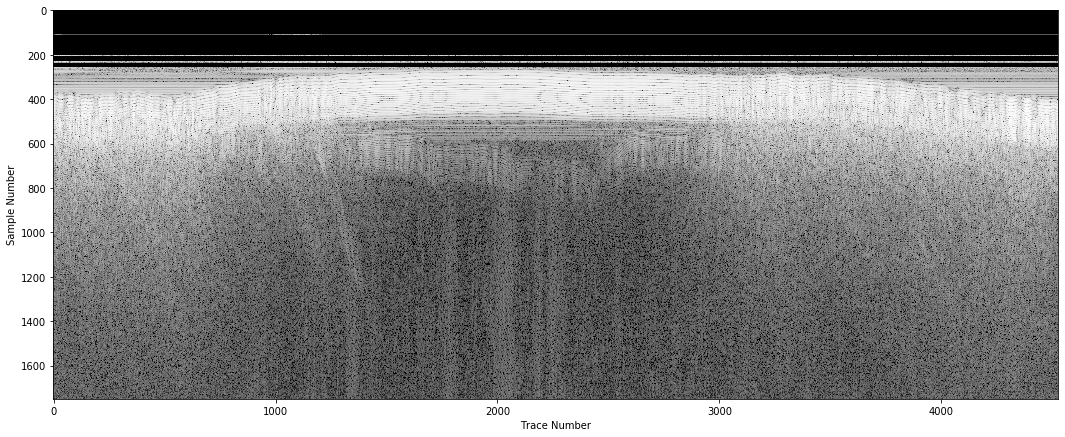

In [62]:
data = sig.loadData("20180819-215243.dat")
fig=plt.figure(figsize=(18, 18))
plt.imshow(np.log(data**2), cmap='Greys_r', vmin=-5, vmax =17)
plt.xlabel("Trace Number")
plt.ylabel("Sample Number")
plt.show()

In [1]:
# Pulse compress here


If you have pulse compressed correctly you can now see the top and bottom of the Malaspina Glacier in Southern Alaska, the largest [piedmont glacier](https://en.wikipedia.org/wiki/Glacier_morphology#Piedmont_glaciers) in te world. [Link to a Landsat 8 OLI image of it](https://earthobservatory.nasa.gov/images/86767/malaspina-glacier-alaska). This flight track that acquired this radargram goes from right to left across the whole glacier in the OLI image, about halfway between the ocean and the mountains. Can you estimate the maximum thickness measured in this radargram, assuming that the speed of the chirp in ice is $1.7\cdot10^8$ m/s?

Thickness - ?